In [1]:
import pandas as pd
import ee
import geemap
import math

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

In [2]:
Map = geemap.Map()

In [3]:
def calculate_square_coordinates(center_lon, center_lat, side_length):
    # Calculate change in longitude (delta_lon)
    delta_lon = (side_length / 111320.0) /3

    # Calculate change in latitude (delta_lat)
    delta_lat = (side_length / 111320.0)/3

    return center_lon + delta_lon, center_lat + delta_lat, center_lon - delta_lon, center_lat - delta_lat


def calculate_bounding_box(center_lon, center_lat, side_length):
    # Radius of the Earth in kilometers
    earth_radius = 6371.0
    side_length = (side_length - 5) /3
    # Convert latitude and longitude from degrees to radians
    center_lat_rad = math.radians(center_lat)
    center_lon_rad = math.radians(center_lon)

    # Calculate the change in coordinates (in radians) for the given side length
    delta_lat = side_length / (earth_radius * math.pi / 180.0)
    delta_lon = side_length / (earth_radius * math.cos(center_lat_rad) * math.pi / 180.0)

    # Calculate the bounding coordinates
    min_lat = center_lat - delta_lat
    max_lat = center_lat + delta_lat
    min_lon = center_lon - delta_lon
    max_lon = center_lon + delta_lon

    return min_lon, min_lat, max_lon, max_lat

# Set the center point and side length 	
center_lon, center_lat = [-111.722081, 57.24118] # Ells River
side_length_meters = 20 #km 

# Calculate square coordinates
square_coordinates = calculate_square_coordinates(center_lon, center_lat, side_length_meters)

square_coordinates = calculate_bounding_box(center_lon, center_lat, side_length_meters)

region = ee.Geometry.BBox(square_coordinates[0], square_coordinates[1], square_coordinates[2], square_coordinates[3])

point = ee.Geometry.Point([center_lon, center_lat])
Map.addLayer(point,{}, "station")

In [4]:
# Set the date range
start_date = '2020-07-01'
end_date = '2020-07-30'

In [5]:
def dynamic_world_s3(
    region=None,
    start_date="2020-01-01",
    end_date="2021-01-01",
    clip=False,
    cloud_pct=0.35,
    reducer=None,
):
    """Create Sentinel-2 composite for the Dynamic World Land Cover product.

    Args:
        region (ee.Geometry | ee.FeatureCollection): The region of interest. Default to None.
        start_date (str | ee.Date): The start date of the query. Default to "2020-01-01".
        end_date (str | ee.Date): The end date of the query. Default to "2021-01-01".
        clip (bool, optional): Whether to clip the image to the region. Default to False.
        cloud_pct (float, optional): The percentage of cloud cover to be used for filtering. Default to 0.35.
        reducer (ee.Reducer, optional): The reducer to be used for creating image composite. Default to None.

    Returns:
        ee.Image: The Sentinel-2 composite.
    """
    s2 = (
        ee.ImageCollection("COPERNICUS/S2_SR")
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct * 100))
    )

    if isinstance(region, ee.FeatureCollection) or isinstance(region, ee.Geometry):
        s2 = s2.filterBounds(region)
    else:
        raise ValueError("region must be an ee.FeatureCollection or ee.Geometry.")

    if reducer is None:
        reducer = ee.Reducer.median()

    image = s2.reduce(reducer).rename(s2.first().bandNames())

    if clip and (region is not None):
        if isinstance(region, ee.Geometry):
            image = image.clip(region)
        elif isinstance(region, ee.FeatureCollection):
            image = image.clipToCollection(region)

    return image

In [6]:
image = dynamic_world_s3(region, start_date, end_date, clip = True)

In [7]:
#image.getInfo()

In [8]:
# Create a Sentinel-2 image composite
image = dynamic_world_s3(region, start_date, end_date, clip = True)
vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3*10000}
Map.addLayer(image, vis_params, 'Sentinel-2 image')

In [9]:
def fill_gap(image):
    # Apply focal_mean operation only to masked pixels
    #filled_image = image.updateMask(image.mask()) \
    #                     .focalMode(radius=2, kernelType='square', units='pixels', iterations=2)

    filled_image = image.focal_mode(radius=2, kernelType='square', units='pixels', iterations=2)
    # Combine the result with the original image
    return filled_image.blend(image)

In [10]:
def dynamic_world(
    region=None,
    start_date="2020-01-01",
    end_date="2021-01-01",
    clip=False,
    reducer=None,
    projection="EPSG:3857",
    scale=10,
    return_type="hillshade",
    fill_gaps = True
):
    """Create 10-m land cover composite based on Dynamic World. The source code is adapted from the following tutorial by Spatial Thoughts:
    https://developers.google.com/earth-engine/tutorials/community/introduction-to-dynamic-world-pt-1

    Args:
        region (ee.Geometry | ee.FeatureCollection): The region of interest.
        start_date (str | ee.Date): The start date of the query. Default to "2020-01-01".
        end_date (str | ee.Date): The end date of the query. Default to "2021-01-01".
        clip (bool, optional): Whether to clip the image to the region. Default to False.
        reducer (ee.Reducer, optional): The reducer to be used. Default to None.
        projection (str, optional): The projection to be used for creating hillshade. Default to "EPSG:3857".
        scale (int, optional): The scale to be used for creating hillshade. Default to 10.
        return_type (str, optional): The type of image to be returned. Can be one of 'hillshade', 'visualize', 'class', or 'probability'. Default to "hillshade".

    Returns:
        ee.Image: The image with the specified return_type.
    """

    if return_type not in ["hillshade", "visualize", "class", "probability"]:
        raise ValueError(
            f"{return_type} must be one of 'hillshade', 'visualize', 'class', or 'probability'."
        )

    if reducer is None:
        reducer = ee.Reducer.mode()

    dw = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1").filter(
        ee.Filter.date(start_date, end_date)
    )
    if fill_gaps:
        dw = dw.map(fill_gap)

    if isinstance(region, ee.FeatureCollection) or isinstance(region, ee.Geometry):
        dw = dw.filterBounds(region)
    else:
        raise ValueError("region must be an ee.FeatureCollection or ee.Geometry.")

    # Create a Mode Composite
    classification = dw.select("label")
    dwComposite = classification.reduce(reducer)
    if clip and (region is not None):
        if isinstance(region, ee.Geometry):
            dwComposite = dwComposite.clip(region)
        elif isinstance(region, ee.FeatureCollection):
            dwComposite = dwComposite.clipToCollection(region)
        elif isinstance(region, ee.Feature):
            dwComposite = dwComposite.clip(region.geometry())

    dwVisParams = {
        "min": 0,
        "max": 8,
        "palette": [
            "#419BDF",
            "#397D49",
            "#88B053",
            "#7A87C6",
            "#E49635",
            "#DFC35A",
            "#C4281B",
            "#A59B8F",
            "#B39FE1",
        ],
    }

    if return_type == "class":
        proj = ee.Projection(projection).atScale(scale)
        dwComposite = dwComposite.setDefaultProjection(proj)
        return dwComposite
    elif return_type == "visualize":
        return dwComposite.visualize(**dwVisParams)
    else:
        # Create a Top-1 Probability Hillshade Visualization
        probabilityBands = [
            "water",
            "trees",
            "grass",
            "flooded_vegetation",
            "crops",
            "shrub_and_scrub",
            "built",
            "bare",
            "snow_and_ice",
        ]

        # Select probability bands
        probabilityCol = dw.select(probabilityBands)

        # Create a multi-band image with the average pixel-wise probability
        # for each band across the time-period
        meanProbability = probabilityCol.reduce(ee.Reducer.mean())

        # Composites have a default projection that is not suitable
        # for hillshade computation.
        # Set a EPSG:3857 projection with 10m scale
        proj = ee.Projection(projection).atScale(scale)
        meanProbability = meanProbability.setDefaultProjection(proj)

        # Create the Top1 Probability Hillshade
        top1Probability = meanProbability.reduce(ee.Reducer.max())

        if clip and (region is not None):
            if isinstance(region, ee.Geometry):
                top1Probability = top1Probability.clip(region)
            elif isinstance(region, ee.FeatureCollection):
                top1Probability = top1Probability.clipToCollection(region)
            elif isinstance(region, ee.Feature):
                top1Probability = top1Probability.clip(region.geometry())

        if return_type == "probability":
            return top1Probability
        else:
            top1Confidence = top1Probability.multiply(100).int()
            hillshade = ee.Terrain.hillshade(top1Confidence).divide(255)
            rgbImage = dwComposite.visualize(**dwVisParams).divide(255)
            probabilityHillshade = rgbImage.multiply(hillshade)

            return probabilityHillshade

In [11]:
def fillGap(image):
  return image.focalMode(6, 'square', 'pixels', 2).rename(image.bandNames()).blend(image)


In [12]:
# Create Dynamic World land cover composite
landcover = dynamic_world(region, start_date, end_date, return_type="hillshade", 
                                 clip = True, scale=10, fill_gaps = False)
Map.addLayer(landcover, {}, 'Land Cover')
Map.addLayer(fillGap(landcover), {}, "Land Cover fill")

In [142]:
#landcover

In [143]:
landcover.focalMode(6, 'square', 'pixels', 2)

In [13]:
# Add legend to the map
Map.add_legend(title="Dynamic World Land Cover", builtin_legend='Dynamic_World')
Map.addLayer(point,{}, "station")
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
# Save Dynamic World class data in GeoTIFF format
#output_path = 'landcover_hillshade.tif'
#geemap.ee_export_image(landcover, filename=output_path, scale=30, region=region, file_per_band=False)

In [49]:
#Create Dynamic World land cover classes
landcover_class = dynamic_world(region, start_date, end_date, return_type="class",  clip = True, scale=5*100)
dwVisParams = {
        "min": 0,
        "max": 8,
        "palette": [
            "#419BDF",
            "#397D49",
            "#88B053",
            "#7A87C6",
            "#E49635",
            "#DFC35A",
            "#C4281B",
            "#A59B8F",
            "#B39FE1",
        ],
    }
Map.addLayer(landcover_class, dwVisParams, "classes")

In [50]:
landcover_class

In [51]:
# Save Dynamic World class data in GeoTIFF format
#output_path = 'landcover_class.tif'
#geemap.ee_export_image(landcover_class, filename=output_path, scale=30, region=region, file_per_band=False)

In [115]:
import numpy as np
landcover_array = geemap.ee_to_numpy(landcover, region=region, scale = 6*1000)

In [116]:
landcover_array

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [67]:
import numpy as np
landcover_array = geemap.ee_to_numpy(landcover_class, region=region, scale = 6*1000)

In [68]:
landcover_array.shape

(4, 4, 1)

In [69]:
landcover_array[:,:,0]

array([[8, 8, 8, 8],
       [8, 8, 8, 8],
       [8, 8, 8, 8],
       [8, 8, 8, 8]], dtype=uint8)

#  Read image

In [ ]:
#! pip install rasterio

In [ ]:
#import rasterio
#import matplotlib.pyplot as plt

# Create an interactive map using geemap
#Map = geemap.Map()
#Map

# Specify the path to your local GeoTIFF file
#local_image_path = "landcover_hillshade.tif"

# Open the GeoTIFF file using rasterio
#with rasterio.open(local_image_path) as src:
    # Read the image data (bands)
#    image_data = src.read()

# Display the first band of the image using matplotlib
#plt.imshow(image_data[0], cmap='viridis')  # Change cmap as needed
#plt.title("Local GeoTIFF Image")
#plt.show()



In [ ]:
# Convert the image data to an Earth Engine Image
#ee_image = geemap.numpy_to_ee(image_data)

# Add the Earth Engine Image to the map
#Map.addLayer(ee_image, {'bands': ['0', '1', '2'], 'min': 0, 'max': 8}, 'Local GeoTIFF Image')

# Display the map
#Map.centerObject(ee_image.geometry(), 10)  # Center the map on the image with a zoom level

#  Download all images with their dates and coordinates

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import ee
import geemap
import math
from io import StringIO


# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

In [2]:
def dynamic_world(
    region=None,
    start_date="2020-01-01",
    end_date="2021-01-01",
    clip=False,
    reducer=None,
    projection="EPSG:3857",
    scale=10,
    return_type="hillshade",
):
    """Create 10-m land cover composite based on Dynamic World. The source code is adapted from the following tutorial by Spatial Thoughts:
    https://developers.google.com/earth-engine/tutorials/community/introduction-to-dynamic-world-pt-1

    Args:
        region (ee.Geometry | ee.FeatureCollection): The region of interest.
        start_date (str | ee.Date): The start date of the query. Default to "2020-01-01".
        end_date (str | ee.Date): The end date of the query. Default to "2021-01-01".
        clip (bool, optional): Whether to clip the image to the region. Default to False.
        reducer (ee.Reducer, optional): The reducer to be used. Default to None.
        projection (str, optional): The projection to be used for creating hillshade. Default to "EPSG:3857".
        scale (int, optional): The scale to be used for creating hillshade. Default to 10.
        return_type (str, optional): The type of image to be returned. Can be one of 'hillshade', 'visualize', 'class', or 'probability'. Default to "hillshade".

    Returns:
        ee.Image: The image with the specified return_type.
    """

    if return_type not in ["hillshade", "visualize", "class", "probability"]:
        raise ValueError(
            f"{return_type} must be one of 'hillshade', 'visualize', 'class', or 'probability'."
        )

    if reducer is None:
        reducer = ee.Reducer.mode()

    dw = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1").filter(
        ee.Filter.date(start_date, end_date)
    )

    if isinstance(region, ee.FeatureCollection) or isinstance(region, ee.Geometry):
        dw = dw.filterBounds(region)
    else:
        raise ValueError("region must be an ee.FeatureCollection or ee.Geometry.")

    # Create a Mode Composite
    classification = dw.select("label")
    dwComposite = classification.reduce(reducer)
    if clip and (region is not None):
        if isinstance(region, ee.Geometry):
            dwComposite = dwComposite.clip(region)
        elif isinstance(region, ee.FeatureCollection):
            dwComposite = dwComposite.clipToCollection(region)
        elif isinstance(region, ee.Feature):
            dwComposite = dwComposite.clip(region.geometry())

    dwVisParams = {
        "min": 0,
        "max": 8,
        "palette": [
            "#419BDF",
            "#397D49",
            "#88B053",
            "#7A87C6",
            "#E49635",
            "#DFC35A",
            "#C4281B",
            "#A59B8F",
            "#B39FE1",
        ],
    }

    if return_type == "class":
        proj = ee.Projection(projection).atScale(scale)
        dwComposite = dwComposite.setDefaultProjection(proj)
        return dwComposite
    elif return_type == "visualize":
        return dwComposite.visualize(**dwVisParams)
    else:
        # Create a Top-1 Probability Hillshade Visualization
        probabilityBands = [
            "water",
            "trees",
            "grass",
            "flooded_vegetation",
            "crops",
            "shrub_and_scrub",
            "built",
            "bare",
            "snow_and_ice",
        ]

        # Select probability bands
        probabilityCol = dw.select(probabilityBands)

        # Create a multi-band image with the average pixel-wise probability
        # for each band across the time-period
        meanProbability = probabilityCol.reduce(ee.Reducer.mean())

        # Composites have a default projection that is not suitable
        # for hillshade computation.
        # Set a EPSG:3857 projection with 10m scale
        proj = ee.Projection(projection).atScale(scale)
        meanProbability = meanProbability.setDefaultProjection(proj)

        # Create the Top1 Probability Hillshade
        top1Probability = meanProbability.reduce(ee.Reducer.max())

        if clip and (region is not None):
            if isinstance(region, ee.Geometry):
                top1Probability = top1Probability.clip(region)
            elif isinstance(region, ee.FeatureCollection):
                top1Probability = top1Probability.clipToCollection(region)
            elif isinstance(region, ee.Feature):
                top1Probability = top1Probability.clip(region.geometry())

        if return_type == "probability":
            return top1Probability
        else:
            top1Confidence = top1Probability.multiply(100).int()
            hillshade = ee.Terrain.hillshade(top1Confidence).divide(255)
            rgbImage = dwComposite.visualize(**dwVisParams).divide(255)
            probabilityHillshade = rgbImage.multiply(hillshade)

            return probabilityHillshade

In [3]:
def matrix2csvString(matrix):
    # Reshape the 2D array into a 1D array
    one_d_array = matrix.reshape(-1)
    
    # Convert the 1D array to a comma-separated string
    csv_string = ','.join(map(str, one_d_array))
    return csv_string

def month_start_end_dates(year):
    month_dates = []
    for month in range(1, 13):
        start_date = datetime(year, month, 1)
        next_month = start_date.replace(day=28) + timedelta(days=4)  # Move to the 1st of the next month
        end_date = next_month - timedelta(days=next_month.day)
        month_dates.append((start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d")))
    return month_dates

def calculate_bounding_box(center_lon, center_lat, side_length_km):
    # Radius of the Earth in kilometers
    earth_radius = 6371.0
    side_length = (side_length_km - 5) /3
    # Convert latitude and longitude from degrees to radians
    center_lat_rad = math.radians(center_lat)
    center_lon_rad = math.radians(center_lon)

    # Calculate the change in coordinates (in radians) for the given side length
    delta_lat = side_length / (earth_radius * math.pi / 180.0)
    delta_lon = side_length / (earth_radius * math.cos(center_lat_rad) * math.pi / 180.0)

    # Calculate the bounding coordinates
    min_lat = center_lat - delta_lat
    max_lat = center_lat + delta_lat
    min_lon = center_lon - delta_lon
    max_lon = center_lon + delta_lon

    return min_lon, min_lat, max_lon, max_lat

def extrat_land_cover_array(start_date, end_date, coordinates, side_length_km=20, scale=30, scale_rgb = 40):
    center_lon, center_lat = coordinates
    square_coordinates = calculate_bounding_box(center_lon, center_lat, side_length_km)
    region = ee.Geometry.BBox(square_coordinates[0], square_coordinates[1], square_coordinates[2], square_coordinates[3])
    # Create Dynamic World land cover classes
    landcover_class = dynamic_world(region, start_date, end_date, return_type="class", clip=True)
    #Change masked values by -9999
    landcover_class = landcover_class.unmask(-9999)
    # Create Dynamic World land cover composite
    landcover = geemap.dynamic_world(region, start_date, end_date, return_type="hillshade",  clip = True)
    #Change masked values by -9999
    Clound_cover = Cloundcover_cover.unmask(-9999)
    landcover = landcover.unmask(-9999)
    # Convert Earth Engine Image to NumPy array
    landcover_class_array = geemap.ee_to_numpy(landcover_class, region=region, scale=scale)
    landcover_array = geemap.ee_to_numpy(landcover, region=region, scale=scale_rgb)
    # Return the first band of the array and change north with surth
    return np.flipud(landcover_class_array[:, :, 0]), np.flipud(landcover_array)


def extratac_land_cover_year(station, coordinates, year, side_length_km = 20, scale=30 , scale_rgb = 40, save= False, save_path = ""):
    # coordinates = (long, lat)
    months = month_start_end_dates(year)  
    center_lon, center_lat = coordinates     
    data = []
    square_coordinates = calculate_bounding_box(center_lon, center_lat, side_length_km)
    
    
    for month in months:
        print(station, month)
        start_date = month[0]
        end_date = month[1]
        image_month_class, image_month = extrat_land_cover_array(start_date, end_date, coordinates, side_length_km , scale,scale_rgb)
        
        
        #Tranform Image into a string to save into .csv
        
        image_month_csv =  matrix2csvString(image_month) 
                                       
        image_month_class_csv = matrix2csvString(image_month_class)                              
        
        data_month = [station, coordinates, \
                         [square_coordinates[0], square_coordinates[1], square_coordinates[2], square_coordinates[3]],\
                         pd.to_datetime(start_date), pd.to_datetime(end_date),\
                         image_month_class_csv, matrix2csvString(np.array(image_month_class.shape)),
                      image_month_csv, matrix2csvString(np.array(image_month.shape))]
        data.append(data_month)
    columns=["Station", "Coordinates", "Polygon", "Start_Date", "End_Date",
            "Land_Cover_Class", "Shape_class(1:1)_"+str(scale)+"m", 
            "Land_Cover_rgb", "Shape_rgb(1:1)"+str(scale_rgb)+"m"]
    if save :
        dataFrame = pd.DataFrame(data, columns=columns)
        dataFrame.to_csv(save_path)
        print("Data was saved as: "+save_path)
        return dataFrame
    else:    
        return pd.DataFrame(data, columns=columns)     
            

def extratac_land_cover(station, coordinates, year_start, year_end, 
                        side_length_km = 20, 
                        scale=30, scale_rgb=40, save=False, save_years= False, save_path = ""):
    data_station = pd.DataFrame()
    for year in range(year_start, year_end+1):
        data_station_year = extratac_land_cover_year(station, coordinates, year, side_length_km, scale, scale_rgb,  save_years, save_path+str(year))
        data_station = pd.concat([data_station, data_station_year], ignore_index=True)
    if save:
       data_station.to_csv(save_path)
       print("Data was saved as: "+save_path)
       return data_station
    else:
        return data_station

In [4]:
#year = 2020
#data_buffalo_year = extratac_land_cover_year("Buffalo Viewpoint", [-111.59410167,56.996265], year,
#                                   side_length_km = 20, scale=30, scale_rgb=30,
#                                   save= True,
#                                  save_path = "./Data_cover_land_stations/"+"Buffalo Viewpoint_"+ "land_cover_"+ str(year) +".csv")


In [5]:
#data_buffalo_year.head()

In [6]:
#data_buffalo = extratac_land_cover("Buffalo Viewpoint", [-111.59410167,56.996265], 2020, 2021,
#                                   side_length_meters = 20000, scale=30,
#                                  save= True,
#                                   save_path = "./Data_cover_land_stations/"+"Buffalo Viewpoint_"+ "land_cover_2019_2023.csv")

# Extract data for sevelar stations

In [7]:
Stations = {
    "Buffalo Viewpoint":[-111.59410167 ,56.996265],
    "Mannix": [-111.482100,56.967964 ],
    "Mildred Lake":[-111.564147, 57.050006],
    "Bertha Ganter – Fort McKay" : [ -111.640583, 57.189428],
    "Anzac": [-111.037975, 56.448908],
    "Athabasca Valley": [-111.39047, 56.73344],
    "Patricia McInnes": [-111.476694, 56.751378] 
}

Stations = {
    "Stony Mountain": [-111.172686, 55.621408],
    "Janvier": [-110.749744,  55.903242],
    "Fort McKay South": [-111.642344, 57.149175],
    "Conklin": [-111.078872, 55.632331]
}

Stations ={
    "Ells River": [-111.722081, 57.241180],
    "Fort Hills": [-111.639688536, 57.3489012253],
    "Barge landing": [-111.599542, 57.198186],
    "Lower camp": [-111.500819, 57.026792]
}

In [8]:
start_year = 2019
end_year = 2023
scale = 6*1000
for station in Stations:
    extratac_land_cover(station, Stations[station], start_year, end_year, 
                        side_length_km = 20, scale=scale, scale_rgb=6*1000,
                       save= True,
                       save_path = "./Data_cover_land_stations/"+station+ "_land_cover_"+
                        str(start_year)+ '_' +str(end_year)+"_Scale_"+str(scale)+"m"+".csv")

Ells River ('2019-01-01', '2019-01-31')
Ells River ('2019-02-01', '2019-02-28')
Ells River ('2019-03-01', '2019-03-31')
Ells River ('2019-04-01', '2019-04-30')
Ells River ('2019-05-01', '2019-05-31')
Ells River ('2019-06-01', '2019-06-30')
Ells River ('2019-07-01', '2019-07-31')
Ells River ('2019-08-01', '2019-08-31')
Ells River ('2019-09-01', '2019-09-30')
Ells River ('2019-10-01', '2019-10-31')
Ells River ('2019-11-01', '2019-11-30')
Ells River ('2019-12-01', '2019-12-31')
Ells River ('2020-01-01', '2020-01-31')
Ells River ('2020-02-01', '2020-02-29')
Ells River ('2020-03-01', '2020-03-31')
Ells River ('2020-04-01', '2020-04-30')
Ells River ('2020-05-01', '2020-05-31')
Ells River ('2020-06-01', '2020-06-30')
Ells River ('2020-07-01', '2020-07-31')
Ells River ('2020-08-01', '2020-08-31')
Ells River ('2020-09-01', '2020-09-30')
Ells River ('2020-10-01', '2020-10-31')
Ells River ('2020-11-01', '2020-11-30')
Ells River ('2020-12-01', '2020-12-31')
Ells River ('2021-01-01', '2021-01-31')


# Reading Data

In [9]:
import pandas as pd

In [10]:
year = 2021
data = pd.read_csv("./Data_cover_land_stations/"+"Ells River_"+ "land_cover_2019_2023_Scale_6000m.csv")

In [11]:
data

,Unnamed: 0,Station,Coordinates,Polygon,Start_Date,End_Date,Land_Cover_Class,Shape_class(1:1)_6000m,Land_Cover_rgb,Shape_rgb(1:1)6000m
0,0,Ells River,"[-111.722081, 57.24118]","[-111.80518163476842, 57.196213919704064, -111...",2019-01-01,2019-01-31,"8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8","4,4","-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999....","4,4,3"
1,1,Ells River,"[-111.722081, 57.24118]","[-111.80518163476842, 57.196213919704064, -111...",2019-02-01,2019-02-28,"8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8","4,4","-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999....","4,4,3"
2,2,Ells River,"[-111.722081, 57.24118]","[-111.80518163476842, 57.196213919704064, -111...",2019-03-01,2019-03-31,"8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8","4,4","-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999....","4,4,3"
3,3,Ells River,"[-111.722081, 57.24118]","[-111.80518163476842, 57.196213919704064, -111...",2019-04-01,2019-04-30,"1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1","4,4","-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999....","4,4,3"
4,4,Ells River,"[-111.722081, 57.24118]","[-111.80518163476842, 57.196213919704064, -111...",2019-05-01,2019-05-31,"1,1,1,1,1,1,1,0,1,1,1,5,1,1,1,1","4,4","-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999....","4,4,3"
5,5,Ells River,"[-111.722081, 57.24118]","[-111.80518163476842, 57.196213919704064, -111...",2019-06-01,2019-06-30,"1,1,1,1,1,5,1,0,1,1,1,1,1,1,1,1","4,4","-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999....","4,4,3"
6,6,Ells River,"[-111.722081, 57.24118]","[-111.80518163476842, 57.196213919704064, -111...",2019-07-01,2019-07-31,"1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1","4,4","-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999....","4,4,3"
7,7,Ells River,"[-111.722081, 57.24118]","[-111.80518163476842, 57.196213919704064, -111...",2019-08-01,2019-08-31,"1,1,-9999,-9999,1,1,1,-9999,1,1,1,1,1,1,4,1","4,4","-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999....","4,4,3"
8,8,Ells River,"[-111.722081, 57.24118]","[-111.80518163476842, 57.196213919704064, -111...",2019-09-01,2019-09-30,"1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1","4,4","-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999....","4,4,3"
9,9,Ells River,"[-111.722081, 57.24118]","[-111.80518163476842, 57.196213919704064, -111...",2019-10-01,2019-10-31,"1,1,1,1,1,5,1,0,1,1,1,1,1,1,1,1","4,4","-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999....","4,4,3"


In [12]:
image = data['Land_Cover_Class'][3]

In [13]:
#image

In [14]:
import numpy as np
# Convert the string to a 2D NumPy array
array_3d = np.fromstring(image, sep=",")

In [15]:
size = data['Shape_class(1:1)_6000m'][0]

In [16]:
size=np.fromstring(size, dtype=int, sep=",")
size

array([4, 4])

In [17]:
def replace_value(arr, old_value, new_value):
    """
    Replace a specific value in a NumPy array.

    Parameters:
    - arr (numpy.ndarray): Input array.
    - old_value: Value to be replaced.
    - new_value: New value.

    Returns:
    - numpy.ndarray: Array with replaced values.
    """
    return np.where(arr == old_value, new_value, arr)

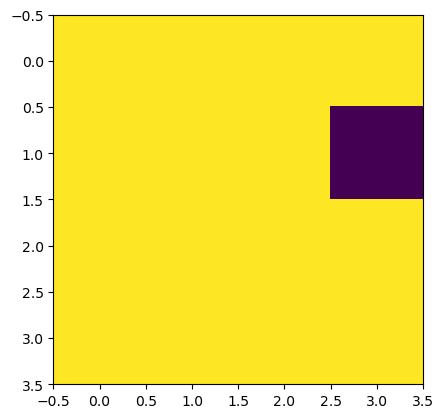

In [18]:
import matplotlib.pyplot as plt
plt.imshow(replace_value(array_3d.reshape(size), -9999, np.NaN))

In [19]:
array_3d.reshape(size)

array([[1., 1., 1., 1.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])